In [1]:
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import hopsworks
import pandas as pd

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/17565
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
iris_df = pd.read_csv("https://repo.hops.works/master/hopsworks-tutorials/data/iris.csv")
iris_df

,sepal_length,sepal_width,petal_length,petal_width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [5]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   variety       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [6]:
iris_df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
iris_df['variety'].value_counts()

variety
Setosa        50
Versicolor    50
Virginica     50
Name: count, dtype: int64

### Exploratory Data Analysis (EDA)  our Iris Data

Let's look at our iris flower - the distribution and range of values for the 4 different features
 * sepal_length
 * sepal_width
 * petal_length
 * petal_width
 
 and the target variable is `variety`.

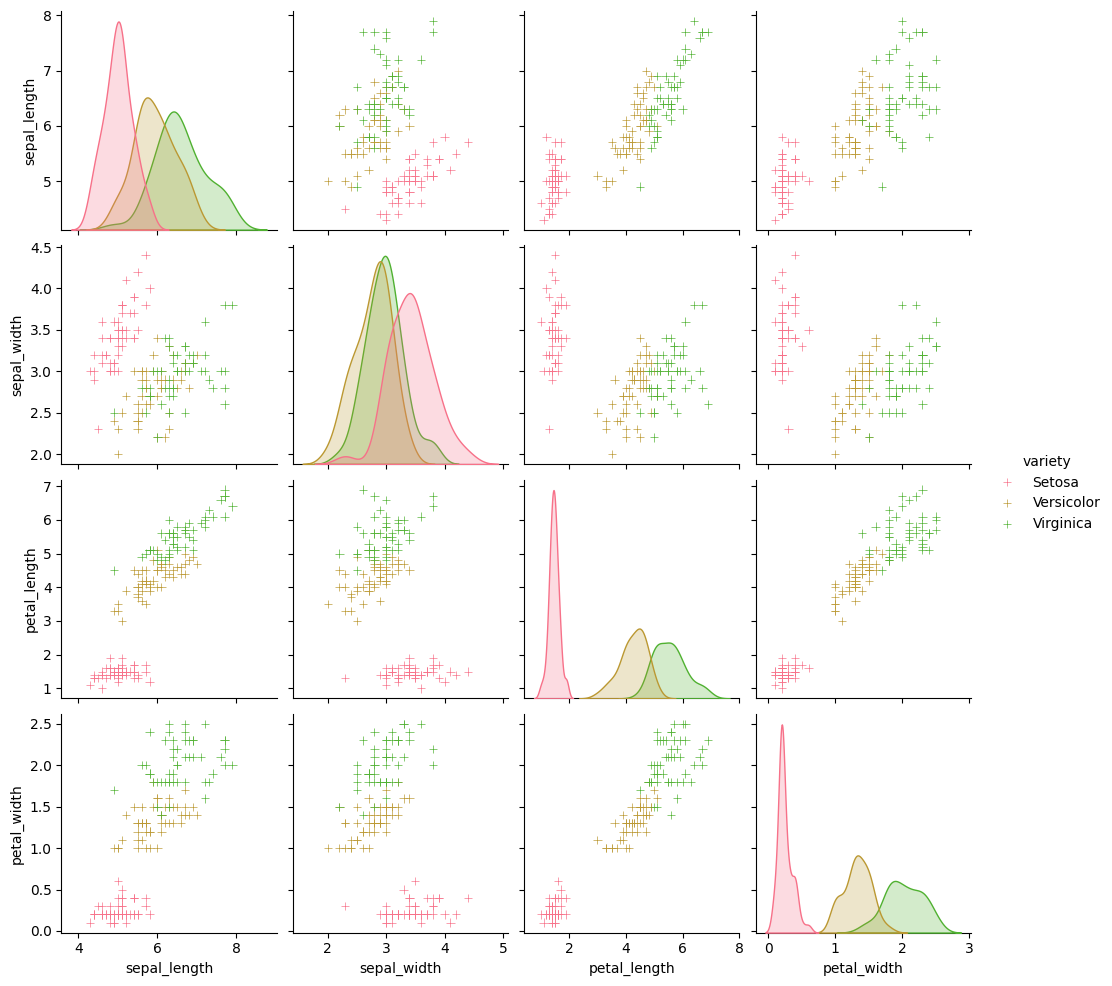

In [8]:
g = sns.pairplot(iris_df, hue='variety', markers='+')
plt.show()

### Visualize range of values 

We want to design a simulator generate the 3 types of iris flower (setosa, versicolor, virginica).
To do this, we can visualize the range of values for the length and width of the sepal and petal for each of the 3 flowers.

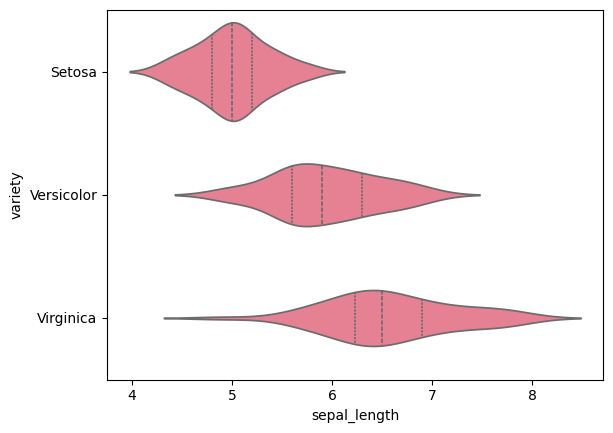

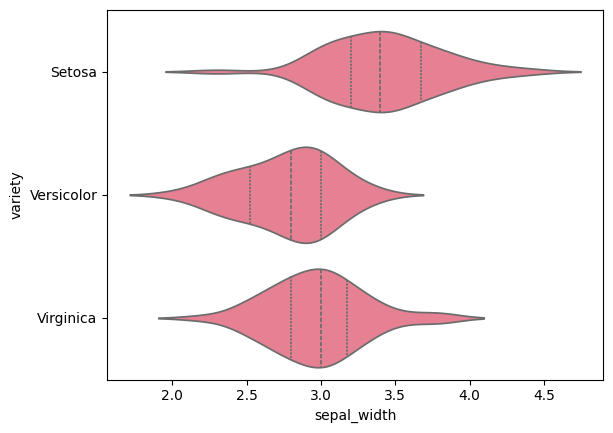

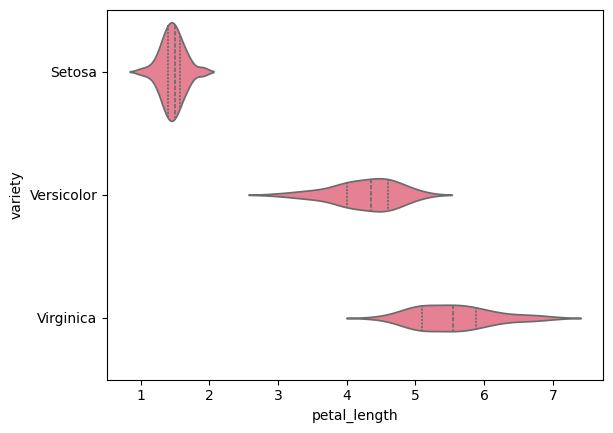

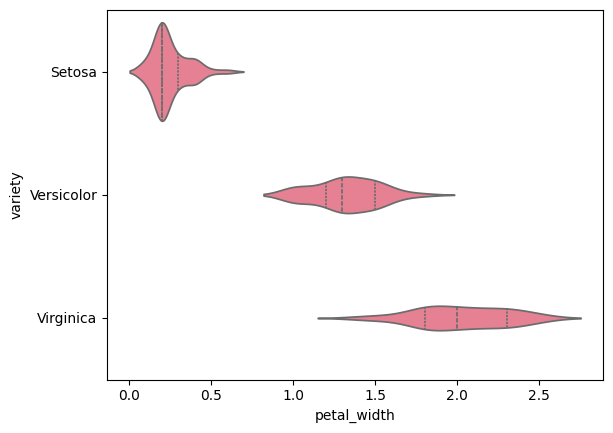

In [9]:
g = sns.violinplot(y='variety', x='sepal_length', data=iris_df, inner='quartile')
plt.show()
g = sns.violinplot(y='variety', x='sepal_width', data=iris_df, inner='quartile')
plt.show()
g = sns.violinplot(y='variety', x='petal_length', data=iris_df, inner='quartile')
plt.show()
g = sns.violinplot(y='variety', x='petal_width', data=iris_df, inner='quartile')
plt.show()

### Insert our Iris DataFrame into a FeatureGroup
Let's write our historical iris feature values and labels to a feature group.
When you write historical data, this process is called `backfilling`.

In [10]:
iris_fg = fs.get_or_create_feature_group(
    name="iris",
    version=1,
    primary_key=["sepal_length","sepal_width","petal_length","petal_width"], 
    description="Iris flower dataset")
iris_fg.insert(iris_df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/17565/fs/17485/fg/186709


Uploading Dataframe: 0.00% |          | Rows 0/150 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: iris_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/17565/jobs/named/iris_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f272ccc1270>, None)

### Data Validation
If you want, you can enable data validation for your feature group.
The code below will prevent iris flower data from being written your your feature group if you write values outside the expected ranges.

In [11]:
from great_expectations.core import ExpectationSuite, ExpectationConfiguration

def expect(suite, column, min_val, max_val):
    suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={
            "column":column, 
            "min_value":min_val,
            "max_value":max_val,
        }
    )
)

In [12]:
suite = ExpectationSuite(expectation_suite_name="iris_dimensions")

expect(suite, "sepal_length", 4.5, 8.0)
expect(suite, "sepal_width", 2.1, 4.5)
expect(suite, "petal_length", 1.2, 7)
expect(suite, "petal_width", 0.2, 2.5)
iris_fg.save_expectation_suite(expectation_suite=suite, validation_ingestion_policy="STRICT")    

Attached expectation suite to Feature Group, edit it at https://c.app.hopsworks.ai:443/p/17565/fs/17485/fg/186709
